# Progetto Gruppo 2
## Segmentazione di Cellule del sangue

**Autori** Fortunato Michela, Iodice Luisa, Minervini Nicolas, Modano Armando

# Fase preliminare
Installiamo easy-cv-dataset che ci servirà

In [ ]:
!pip install --upgrade git+https://github.com/davin11/easy-cv-dataset keras-hub

  Cloning https://github.com/davin11/easy-cv-dataset to /tmp/pip-req-build-jivsr5px
  Running command git clone --filter=blob:none --quiet https://github.com/davin11/easy-cv-dataset /tmp/pip-req-build-jivsr5px
  Resolved https://github.com/davin11/easy-cv-dataset to commit 4fb5d674bada5fcc920dfff806579c156c8810d9
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 62.9 MB/s eta 0:00:00
  Created wheel for easy-cv-dataset: filename=easy_cv_dataset-0.2.1-py3-none-any.whl size=38544 sha256=74aab0c7bf56e0e313c13350bb0968540f01c1ee21ac2721512eda1914bc2776
  Stored in directory: /tmp/pip-ephem-wheel-cache-s_1n7vxm/wheels/4b/01/2c/2ee8db9e6bf6e0fed457316daacdfad5fa4ef7679bc1d784b1
Successfully built easy-cv-dataset
  Attempting uninstall: keras-hub
    Found existing installation: keras-hub 0.21.1
    Uninstalling keras-hub-0.21.1:
      Successfully uninst

Scarichiamo ed estraiamo il dataset

In [ ]:
!wget --user=corso --password=corso2025f https://www.grip.unina.it/download/corso/bbbc041seg-DatasetNinja.tar
!tar --skip-old-files -xf bbbc041seg-DatasetNinja.tar

--2025-12-11 16:27:35--  https://www.grip.unina.it/download/corso/bbbc041seg-DatasetNinja.tar
Resolving www.grip.unina.it (www.grip.unina.it)... 143.225.28.237
Connecting to www.grip.unina.it (www.grip.unina.it)|143.225.28.237|:443... connected.
HTTP request sent, awaiting response... 401 Unauthorized
Authentication selected: Basic realm="corso"
Reusing existing connection to www.grip.unina.it:443.
HTTP request sent, awaiting response... 200 OK
Length: 2357852160 (2.2G) [application/x-tar]
Saving to: ‘bbbc041seg-DatasetNinja.tar’

bbbc041seg-DatasetN 100%[===================>]   2.20G  5.48MB/s    in 4m 32s  

2025-12-11 16:32:09 (8.27 MB/s) - ‘bbbc041seg-DatasetNinja.tar’ saved [2357852160/2357852160]



Scarichiamo lo script "create-msk.py" per la creazione delle maschere<br>
Per evitare di dover importate manualmente ogni volta lo script "create_msk.py" è stato caricato su un GitHub personale e si scarica direttamente da lì<br>
Creiamo anche le maschere

In [ ]:
SITE = "https://raw.githubusercontent.com/Nicolas1617/university_projects/refs/heads/main/VSR%20project%20work"
!wget -nc {SITE}/create_msk.py
!python create_msk.py

--2025-12-11 16:32:25--  https://raw.githubusercontent.com/Nicolas1617/university_projects/refs/heads/main/VSR%20project%20work/create_msk.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1565 (1.5K) [text/plain]
Saving to: ‘create_msk.py’

create_msk.py       100%[===================>]   1.53K  --.-KB/s    in 0s      

2025-12-11 16:32:26 (31.5 MB/s) - ‘create_msk.py’ saved [1565/1565]

  0% 0/1328 [00:00<?, ?it/s]/content/create_msk.py:49: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  msk = Image.fromarray(np.uint8(msk.clip(0,1)), mode='P')
100% 1328/1328 [00:41<00:00, 31.67it/s]


# Import di base
Come prima cosa puliamo le variabili e importiamo le librerie che sicuramente ci serviranno, altre librerie le importeremo man mano all'occorrenza

In [ ]:
%reset -f
import numpy as np
import matplotlib.pyplot as plt
import skimage.io as io
import keras
import keras_hub
import easy_cv_dataset as ds

# Creazione delle tabelle di train e test
Di seguito creiamo le tabelle per i dati di train e di test

In [ ]:
from glob import glob
import pandas
list_train_img_path = [] #creiamo una lista vuota
list_train_msk_path = glob('train/msk/*.png')
for name in list_train_msk_path:
    name=name[:-4]
    name=name.replace('/msk/','/img/')
    list_train_img_path.append(name)

tab_train = pandas.DataFrame({'image': list_train_img_path,
                        'segmentation_mask': list_train_msk_path})
tab_train.to_csv('train_table.csv')

Abbiamo visto che le immagini non erano tutte .png ma c'erano anche alcune .jpg, per questo motivo abbiamo creato il vettore **list_img_path** a partire dal vettore **list_msk_path**.
Per farlo abbiamo confrontato i nomi delle immagini e delle maschere e abbiamo visto che i nomi delle maschere avevano 4 caratteri in più per questo motivo il vettore name prende tutti i caratteri tranne gli ultimi 4.
Abbiamo seguito questa procedura e non preso anche i file .jpg dalla cartella img perché altrimenti non avremmo avuto la certezza che maschera e immagine corrispondessero
Dato che siamo partiti dalla cartella delle maschere oltre ad accorciare il nome abbiamo dovuto sostituire la stringa **/msk/** con la stringa **/img/**

In [ ]:
# abbiamo stampato queste cose per capire come mai desse errore sulla lunghezza
#print(len(list_img_path))
#print(len(list_msk_path))
#print(list_msk_path[0])
#print(list_img_path[0])

In [ ]:
list_test_img_path = []
list_test_msk_path = glob('test/msk/*.png')
for name in list_test_msk_path:
    name=name[:-4] #il nome della maschera ha 4 caratteri in più per questo ci creiamo un nome con 4 caratteri in meno
    name=name.replace('/msk/','/img/')
    list_test_img_path.append(name)

tab_test = pandas.DataFrame({'image': list_test_img_path,
                        'segmentation_mask': list_test_msk_path})
tab_test.to_csv('test_table.csv')

# Creazione validation set
Di seguito creiamo il validation set che sarà comporsto da 159 elementi presi in maniera causale dal train set

In [ ]:
from sklearn.model_selection import train_test_split

tab_tran, tab_valid = train_test_split(tab_train, test_size=159, random_state=34)
tab_valid.to_csv('valid_table.csv')

# [Augmentation](https://keras.io/api/layers/preprocessing_layers/image_augmentation/)
Abbiamo deciso di fare operazioni random di variazione di luminosità, di rotazione e flip.<br>
La variazione di luminosità va in un range -20%,+20%<br>
La rotazione va da -5° a +5°<br>
Il flip è fatto in orizzontale

In [ ]:
#augmentation
from keras.layers import Pipeline, RandomBrightness, RandomRotation, RandomFlip
augmenter = Pipeline(layers=[
    RandomBrightness(factor=(-0.2, 0.2), value_range=(0, 255)),
    RandomRotation((-0.05,0.05)),
    RandomFlip("horizontal")])

In [ ]:
batch_size = 16
image_size = 512
class_names = ["Background", "Foreground"]
num_classes = 2
from keras.layers import Resizing
pre_batching_processing = Resizing(image_size, image_size)
post_batching_processing = augmenter

print('test-set')
test_ds = ds.image_segmentation_dataset_from_dataframe(
    'test_table.csv',
    class_mode='categorical', class_names=class_names,
    pre_batching_processing=pre_batching_processing,
    shuffle=False, batch_size=batch_size) #nel test set non ha senso fare shuffle, ha senso solo nel training set

print('trainig-set')
train_ds = ds.image_segmentation_dataset_from_dataframe(
    'train_table.csv',
    class_mode='categorical', class_names=class_names,
    pre_batching_processing=pre_batching_processing,
    shuffle=True , batch_size=batch_size,
    post_batching_processing=post_batching_processing)

print('validation-set')
valid_ds = ds.image_segmentation_dataset_from_dataframe(
    'valid_table.csv',
    class_mode='categorical', class_names=class_names,
    pre_batching_processing=pre_batching_processing,
    shuffle=False, batch_size=batch_size)

test-set
trainig-set
shuffling with buffer_size 160
validation-set


# Visualizzazione
Di seguito visualizziamo un batch di immagini con la relativa mappa di segmentazione

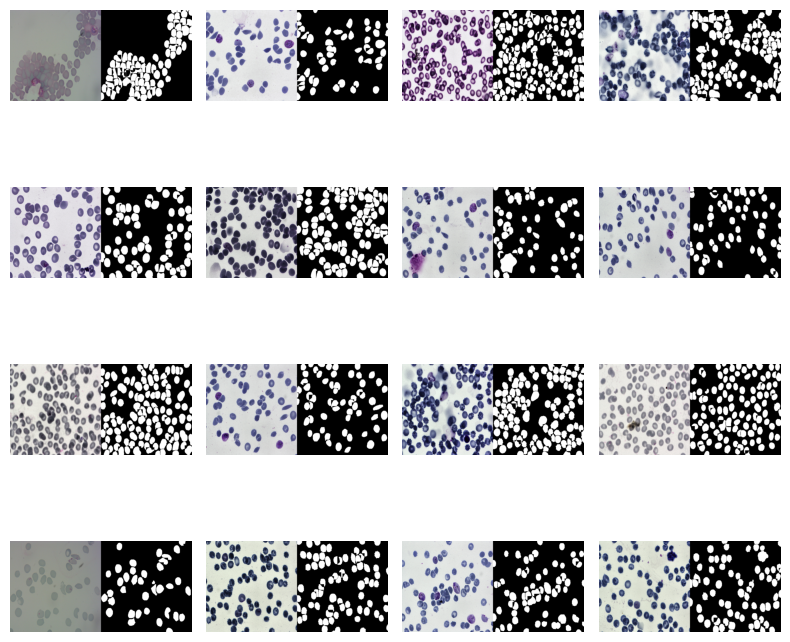

In [ ]:
from easy_cv_dataset.visualization import plot_segmentation_mask_gallery

for images, segms in test_ds.take(1): # il for scorre solo sul primo batch
    plot_segmentation_mask_gallery( # funzione per visualizzare image and box
    images, y_true = segms, num_classes = num_classes
)

# Importazione modello pre-addestrato
[mit_b0_ade20k_512](https://www.kaggle.com/models/keras/mit/keras/mit_b0_ade20k_512/4)

In [ ]:
from keras_hub.models import MiTBackbone, SegFormerBackbone
from keras_hub.models import SegFormerImageSegmenter
from keras_hub.models import ImageSegmenterPreprocessor as pre

preprocessor = pre.from_preset("segformer_b0_ade20k_512")
encoder = MiTBackbone.from_preset("mit_b0_ade20k_512",
    load_weights=True,
    image_shape=(image_size, image_size, 3),
)
backbone = SegFormerBackbone(
    image_encoder=encoder,
    projection_filters=256,
    )
model = SegFormerImageSegmenter(
    preprocessor=preprocessor,
    backbone=backbone,
    num_classes=num_classes,
    activation=None #abbiamo messo None perché in seguito mettiamo logit=True
    )
model.summary()

100%|██████████| 1.66k/1.66k [00:00<00:00, 3.87MB/s]


100%|██████████| 977/977 [00:00<00:00, 1.77MB/s]


Preprocessor: "seg_former_image_segmenter_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                                  ┃                                   Config ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ seg_former_image_converter (SegFormerImageConverter)          │                   Image size: (512, 512) │
└───────────────────────────────────────────────────────────────┴──────────────────────────────────────────┘

Model: "seg_former_image_segmenter"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                                  ┃ Output Shape                       ┃             Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)                    │ (None, 512, 512, 3)                │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ seg_former_backbone (SegFormerBackbone)       │ (None, 128, 128, 256)              │           3,714,656 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ dropout_16 (Dropout)                          │ (None, 128, 128, 256)              │                   0 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ conv2d_11 (Conv2D)                            │ (None, 128, 128, 2)                │                 514 │
├───────────────────────────────────────────────┼────────────────────────────────────┼─────────────────────┤
│ resizing_2 (Resizing)                         │ (None, 512, 512, 2)                │                   0 │
└───────────────────────────────────────────────┴────────────────────────────────────┴─────────────────────┘

 Total params: 3,715,170 (14.17 MB)

 Trainable params: 3,714,658 (14.17 MB)

 Non-trainable params: 512 (2.00 KB)

# Train Backbone
Conviene non bloccare il backbone ma riaddestrarlo perché il modello è pre addestrato su un dataset molto diverso dal nostro.<br>
Abbiamo anche effettuato una prova con backbone bloccato e abbiamo visto un valore di circa 0.78 con backbone bloccato a fronte di un valore di circa 0.92 con backbone riaddestrato

In [ ]:
#model.backbone.trainable = False
#model.summary()
#abbiamo deciso di addestrare anche il backbone come test e abbiamo visto che siamo passati da 0.78 a 0.91

# Learning Rate variabile
Ha senso usare uno schedule del learning rate in modo da avere una rete che segue più step
- **Step 1** learning rate alto per un adattamento rapido
- **Step 2** learning rate più basso per stabilizzazione
- **Step 3** learning rate ancora più basso per finalizzazione

In [ ]:
base_lr = 0.001 #definiamo un learning rate (lr) di partenza
from keras import optimizers

lr_decay = optimizers.schedules.PiecewiseConstantDecay( #schedulatore del lr, serve per ridurre il lr secondo uno scheduling
    boundaries=[5*len(train_ds), 10*len(train_ds)], #qui diciamo che deve ridurre dopo 5 epoche e dopo 10 epoche
    values=[base_lr, 0.1 * base_lr, 0.01 * base_lr], #qui diciamo di quanto deve ridurre il lr
)
optimizer = optimizers.Nadam(
    learning_rate=lr_decay, global_clipnorm=10.0
)

# [Early Stop](https://keras.io/api/callbacks/early_stopping/)
L'eraly stop è una tecnica che permette di fermare l'addestramento in base ad alcuni criteri stabiliti:
- **monitor** indica il valore da monitorare, nel nostro caso abbiamo deciso di controllare la loss sulla validation
- **min_delta** indica la variazione minima da rispettare, nel nostro caso abbiamo detto che ci deve essere una variazione di almeno 0.001
- **patience** indica il numero di epoche su cui controllare il valore di min_delta
- **mode** indica che cosa stiamo facendo con il valore da monitorare, noi abbiamo indicato che vogliamo minimizzarlo
- **restore_best_weights** ci chiede se vogliamo tornare o meno al peso migliore ottenuto durante il training
- **start_from_epoch** chiede da quale epoca far iniziare il monitoraggio

Il fatto di avere impostato min come mode fa si che la variazione debba essere sempre verso la minimizzazione, altimenti anche un peggioramento con un delta di almeno 0.001 andrebbe bene, cosa che non vogliamo.<br>
Abbiamo deciso di impostare un'epoca di inizio perché abbiamo notato che altrimenti ci fermava troppo presto dato che con lr grande si verificavano delle variazioni di loss verso l'alto che ci facevano fermare l'addestramento troppo presto e in più perché non ci serve tanto per evitare overfitting ma per trovare un numero di epoche adatto per fermare l'addestramento quando non ci sono più miglioramenti per questo abbiamo deciso di far partire l'early stop quando stiamo addestrando con il lr più piccolo.<br>
In più abbiamo deciso di mettere ripristinare il peso migliore perché se l'addestramento si ferma per mancanza di miglioramenti il peso migliore sarà comunque quello dell'ultima epoca, ma se l'addestramento si ferma perché la loss stava peggiorando non conviene più prendere il peso dell'ultima epoca ma quello della migliore del training.

Altro vantaggio dell'Early Stop è quello di poter impostare un numero di epoche abbastanza alto in quanto l'addestramento si dovrebbe fermare prima, quindi quello di addestrare sul maggior numero di epoche possibili

In [ ]:
#definiamo l'early stopping
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(
    monitor='val_loss',         #guardo la loss di validazione
    min_delta=0.001,            #serve un miglioramento almeno di 0.001
    patience=3,                 #se per 3 epoche non migliora, mi fermo
    mode='min',                 #voglio minimizzare la loss
    restore_best_weights=True,  #torno ai pesi migliori
    start_from_epoch=10         #epoca dalla quale partire con il monitoraggio
)

# Loss function

In [ ]:
from keras.losses import CategoricalCrossentropy
from keras.optimizers import Nadam
from keras.metrics import MeanIoU
model.compile(
    loss=CategoricalCrossentropy(from_logits=True), #mettiamo True perché non abbiamo messo la softmax prima, questa scelta è migliore per questioni di arrotondamento sul calcolatore
    optimizer=optimizer, #nadam è una variante della discesa lungo il gradiente stocastico
    metrics=[MeanIoU(num_classes=2, sparse_y_true=False, sparse_y_pred=False),], #non usiamo l'accuracy per quanto detto in teoria
)

# Addestramento
Di seguito addestriamo la rete specificando il train set, il validation set, il numero di epoche ed altri fattori tipo il verbose che permette di visualizzare una barra di progresso e la callback che ci permette di richiamare il nostro earlystop<br>
Dopo aver addestrato salviamo i pesi in un file

In [ ]:
gruppo_2 = model.fit(train_ds, epochs=30, validation_data=valid_ds, verbose=True, callbacks=[early_stop])
model.save_weights('gruppo_2.weights.h5')

Epoch 1/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 342s 3s/step - loss: 0.2486 - mean_io_u: 0.7881 - val_loss: 0.1008 - val_mean_io_u: 0.9011
Epoch 2/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - loss: 0.1082 - mean_io_u: 0.9044 - val_loss: 0.0904 - val_mean_io_u: 0.9134
Epoch 3/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - loss: 0.0952 - mean_io_u: 0.9149 - val_loss: 0.0923 - val_mean_io_u: 0.9073
Epoch 4/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - loss: 0.0913 - mean_io_u: 0.9182 - val_loss: 0.0813 - val_mean_io_u: 0.9197
Epoch 5/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - loss: 0.0880 - mean_io_u: 0.9213 - val_loss: 0.0796 - val_mean_io_u: 0.9215
Epoch 6/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 140s 2s/step - loss: 0.0868 - mean_io_u: 0.9226 - val_loss: 0.0792 - val_mean_io_u: 0.9230
Epoch 7/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 148s 2s/step - loss: 0.0842 - mean_io_u: 0.9246 - val_loss: 0.0776 - val_mean_io_u: 0.9238
Epoch 8/30
74/74 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - loss: 0.0843 - mean_io_u: 0.9244 - val_loss:

# Visualizzazione grafica andamento loss
Di seguito effettuiamo una visualizzazione grafica di come sta andando la loss e la loss sulla validation in modo da avere ad impatto grafico un'idea di quello che sta succedendo

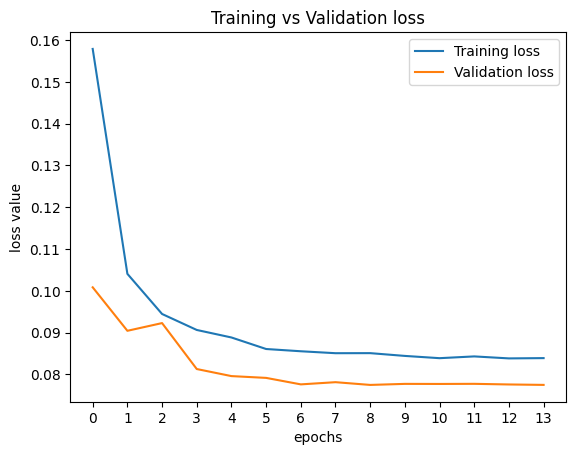

In [ ]:
epoche = len(gruppo_2.history['loss']) #calcolo il numero di epoche come numero di valori di loss

plt.plot(gruppo_2.history['loss'], label='Training loss') #plotta la curva della training loss
plt.plot(gruppo_2.history['val_loss'], label='Validation loss') #plotta la curva della validation loss
plt.xticks(np.arange(epoche)) #setta l'asse x con i valori del numero di epoche
plt.xlabel('epochs') #rinomina l'asse x
plt.ylabel('loss value') #rinomina l'asse y
plt.title('Training vs Validation loss') #da un titolo al grafico
plt.legend() #crea una legenda
plt.show()

In [ ]:
plt.plot(gruppo_2.history['mean_io_u'], label='Mean_io_u')
plt.plot(gruppo_2.history['val_mean_io_u'], label='Validation Mean_io_u')
plt.xticks(np.arange(epoche))
plt.xlabel('epochs')
plt.ylabel('Mean IoU value')
plt.title('Training vs Validation Mean IoU')
plt.legend()
plt.show()

# Test rete

In [ ]:
metrics = model.evaluate(test_ds, return_dict=True, verbose=True)
print(metrics)

10/10 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - loss: 0.0826 - mean_io_u: 0.9215
{'loss': 0.08255074918270111, 'mean_io_u': 0.9224648475646973}


# Visualizzazion del risultato

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


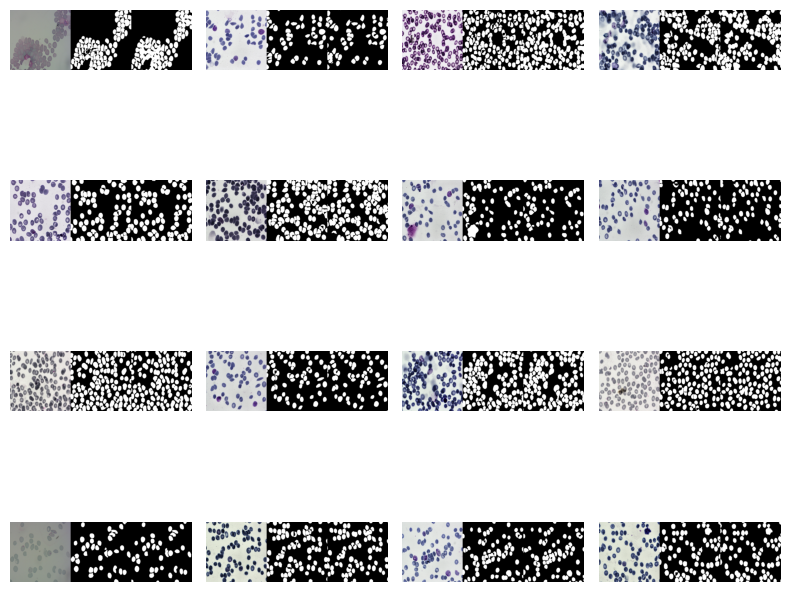

(16, 512, 512, 2)


In [ ]:
#visualizziamo il risultato
from easy_cv_dataset.visualization import plot_segmentation_mask_gallery
for images, segms in test_ds.take(1): #prendiamo il primo batch del testset
    pred = model.predict(images) #lanciamo la rete sul singolo batch con il comando predict
    plot_segmentation_mask_gallery(
        images, y_true=segms, y_pred=pred, num_classes=num_classes
    )
print(pred.shape)

# Conteggio cellule

Cellule reali contate:  93
Cellule predette contate:  68


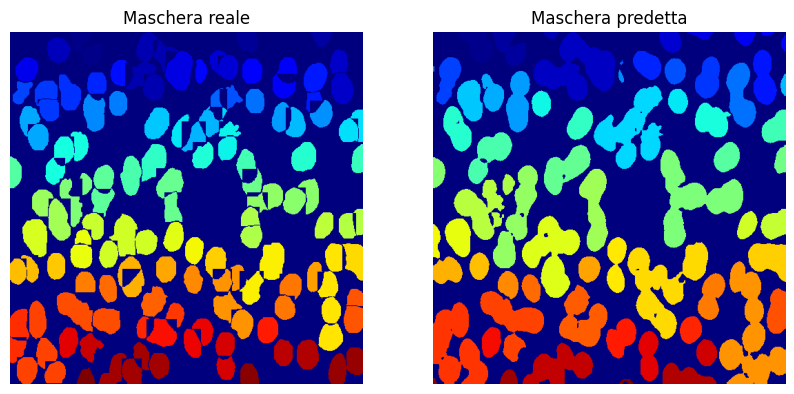

In [ ]:
from skimage.measure import label
index = 2
mask_pred, num_pred = label(pred[index,:,:,1]>0, background=None, return_num=True, connectivity=None)
mask_true, num_true = label(segms[index,:,:,1]>0, background=None, return_num=True, connectivity=None)
print('Cellule reali contate: ',num_true)
print('Cellule predette contate: ',num_pred)
plt.figure(figsize=(10,6))
plt.subplot(1,2,1)
plt.imshow(mask_true, cmap='jet')
plt.title('Maschera reale')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(mask_pred, cmap='jet')
plt.title('Maschera predetta')
plt.axis('off')
plt.show()

# Identificazione cellule

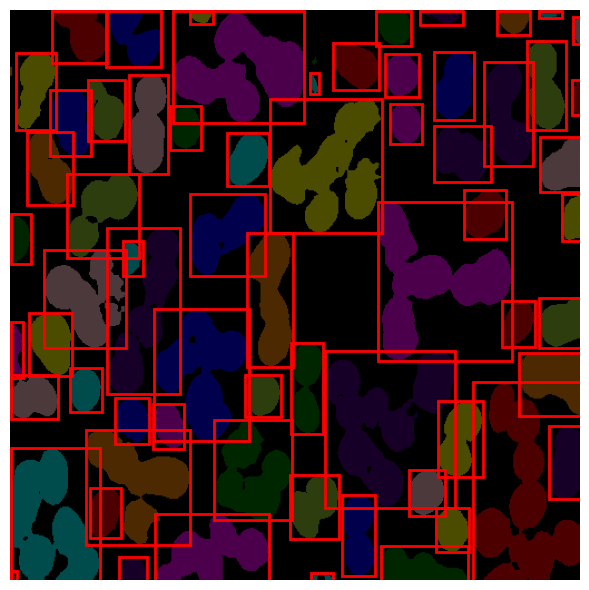

In [ ]:
import matplotlib.patches as mpatches

from skimage.filters import threshold_otsu
from skimage.segmentation import clear_border
from skimage.measure import label, regionprops
from skimage.morphology import closing, footprint_rectangle
from skimage.color import label2rgb

# label image regions
label_image = label(mask_pred)
# to make the background transparent, pass the value of `bg_label`,
# and leave `bg_color` as `None` and `kind` as `overlay`
image_label_overlay = label2rgb(label_image, image=mask_pred, bg_label=0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.imshow(image_label_overlay)

for region in regionprops(label_image):
    # take regions with large enough areas
    if region.area >= 20:
        # draw rectangle around segmented cells
        minr, minc, maxr, maxc = region.bbox
        rect = mpatches.Rectangle(
            (minc, minr),
            maxc - minc,
            maxr - minr,
            fill=False,
            edgecolor='red',
            linewidth=2,
        )
        ax.add_patch(rect)

ax.set_axis_off()
plt.tight_layout()
plt.show()